### Import libraries

In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import decomposition
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

### Import data

In [126]:
# The training arrayCGH dataset (processed)
df_training = pd.read_csv('data/training_data.csv', index_col=0)

# The NClone data extracted from the arrayCGH dataset
df_nclone = pd.read_csv('data/nclone.csv', index_col=0)

# The training class labels
df_labels = pd.read_table('data/labels.txt', index_col=0)

### Nclone Training Method

### ANOVA Training Method

### Baseline Training Method

Fold 1
    Best score:        0.5875
    Best max_depth:    3
    Best n_estimators: 150

Fold 2
    Best score:        0.6125
    Best max_depth:    7
    Best n_estimators: 50

Fold 3
    Best score:        0.6875
    Best max_depth:    7
    Best n_estimators: 200

Fold 4
    Best score:        0.7
    Best max_depth:    7
    Best n_estimators: 150

Fold 5
    Best score:        0.5249999999999999
    Best max_depth:    7
    Best n_estimators: 50

Inner loop accuracy scores: 0.5875, 0.6125, 0.6875, 0.7000, 0.5250
Outer loop accuracy scores: 0.80, 0.65, 0.65, 0.65, 0.80
Average score: 0.71


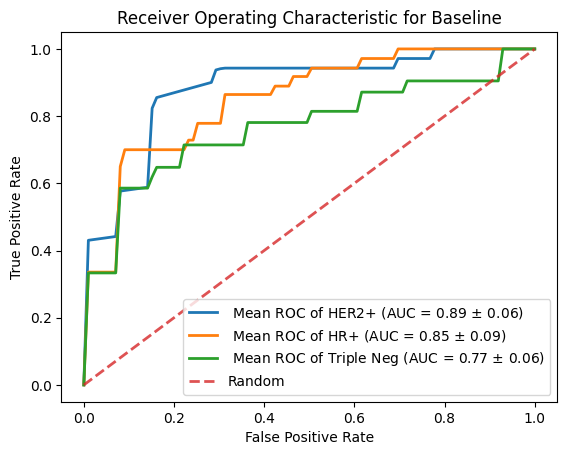

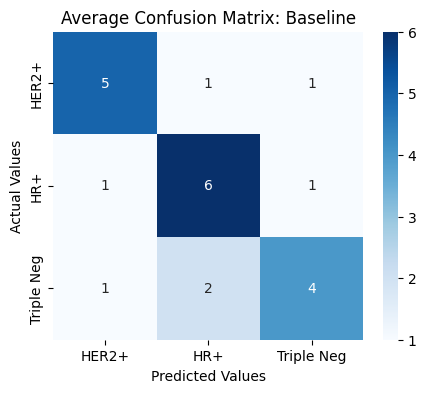

In [127]:
# Initialize stratified k-fold cross-validator for the outer loop with 5 splits, shuffling, and a fixed random seed for reproducibility
outer_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Initialize stratified k-fold cross-validator for the inner loop with 2 splits, shuffling, and a fixed random seed for reproducibility
inner_kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)

# Define the parameter grid for hyperparameter tuning of the RandomForestClassifier
params = {'max_depth': [3, 5, 7, None], 'n_estimators': [50, 100, 150, 200]}

# Initialize a RandomForestClassifier with a fixed random seed for reproducibility
rf_classifier = RandomForestClassifier(random_state=1)

# List to store accuracy scores from the outer loop (test set performance)
outer_loop_accuracy_scores = []

# Dictionary to store the best hyperparameters from the inner loop for each fold
inner_loop_won_params = {}

# Dictionary to store the best accuracy scores from the inner loop for each fold
inner_loop_accuracy_scores = {}

# List to store confusion matrices for each fold
confusion_matrices = []

# Dictionary to store mean true positive rates for ROC curves for each class
mean_tpr = dict()

# Generate 100 evenly spaced numbers between 0 and 1 for the mean false positive rate
mean_fpr = np.linspace(0, 1, 100)

# Dictionary to store mean AUC scores for each class
mean_auc = {}

# Define the class labels
labels = ['HER2+', 'HR+', 'Triple Neg']

# Number of classes
n_classes = len(labels)

# Initialize mean true positive rate and AUC for each class
for i in range(n_classes):
    mean_tpr[i] = 0.0
    mean_auc[i] = {}

# Outer loop: iterate through each fold in the outer stratified k-fold cross-validator
for i, (train_index, test_index) in enumerate(outer_kf.split(df_training, df_labels['Subgroup'])):

    # Initialize GridSearchCV with the RandomForestClassifier and parameter grid, using the inner cross-validator
    GSCV = GridSearchCV(estimator=rf_classifier, param_grid=params, cv=inner_kf)
    
    # Fit GridSearchCV to the training data of the current outer fold
    GSCV.fit(df_training.iloc[train_index], df_labels.loc[df_labels.index[train_index], 'Subgroup'])
    
    # Store the best hyperparameters from the inner loop for the current outer fold
    inner_loop_won_params[i] = GSCV.best_params_
    
    # Store the best score from the inner loop for the current outer fold
    inner_loop_accuracy_scores[i] = GSCV.best_score_

    # Retrieve the best score and hyperparameters for the current outer fold
    best_score = GSCV.best_score_
    best_max_depth = GSCV.best_params_['max_depth']
    best_n_estimators = GSCV.best_params_['n_estimators']

    # Print the best score and hyperparameters for the current outer fold
    print(f'Fold {i + 1}')
    print(f'    Best score:        {best_score}')
    print(f'    Best max_depth:    {best_max_depth}')
    print(f'    Best n_estimators: {best_n_estimators}\n')

    # Initialize a new RandomForestClassifier with the best hyperparameters and fixed random seed
    rf_classifier = RandomForestClassifier(**GSCV.best_params_, random_state=1)
    
    # Train the RandomForestClassifier on the training data of the current outer fold
    rf_classifier.fit(df_training.iloc[train_index], df_labels.loc[df_labels.index[train_index], 'Subgroup'])
    
    # Predict the labels for the test data of the current outer fold
    y_pred = rf_classifier.predict(df_training.iloc[test_index])
    
    # Append the accuracy score for the current outer fold to the list
    outer_loop_accuracy_scores.append(accuracy_score(df_labels.loc[df_labels.index[test_index], 'Subgroup'], y_pred))
    
    # Append the confusion matrix for the current outer fold to the list
    confusion_matrices.append(pd.DataFrame(confusion_matrix(df_labels.loc[df_labels.index[test_index], 'Subgroup'], y_pred, labels=labels)))
    
    # Binarize the test labels for ROC curve calculation
    y_test_bin = label_binarize(df_labels.loc[df_labels.index[test_index], 'Subgroup'], classes=np.unique(df_labels))

    # Calculate the ROC curve and AUC for each class
    for j in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, j], rf_classifier.predict_proba(df_training.iloc[test_index])[:, j])
        mean_tpr[j] += np.interp(mean_fpr, fpr, tpr)
        mean_tpr[j][0] = 0.0
        mean_auc[j][i] = auc(fpr, tpr)

# Convert inner and outer loop accuracy scores to a formatted string
inner_loop_scores_str = ', '.join([f'{score:.4f}' for score in inner_loop_accuracy_scores.values()])
outer_loop_scores_str = ', '.join([f'{score:.2f}' for score in outer_loop_accuracy_scores])

# Calculate the average outer loop accuracy score
average_outer_score = np.mean(outer_loop_accuracy_scores)

# Print the formatted inner loop accuracy scores
print(f'Inner loop accuracy scores: {inner_loop_scores_str}')

# Print the formatted outer loop accuracy scores
print(f'Outer loop accuracy scores: {outer_loop_scores_str}')

# Print the average outer loop accuracy score
print(f'Average score: {average_outer_score:.2f}')

# Average the true positive rates for each class and plot the ROC curve
for i in range(n_classes):
    mean_tpr[i] /= 5
    roc_auc = np.mean(list(mean_auc[i].values()))
    std_auc = np.std(list(mean_auc[i].values()))
    plt.plot(mean_fpr, mean_tpr[i], lw=2, label=' Mean ROC of {0} (AUC = {1:.2f} $\pm$ {2:.2f})'.format(labels[i], roc_auc, std_auc))

# Plot a random chance line for comparison
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, label='Random', alpha=.8)

# Set the plot labels and title and show the ROC plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Baseline')
plt.legend(loc="lower right")
plt.show()

# Concatenate confusion matrices from all folds and group by index
cm_concat = pd.concat(confusion_matrices)
cm_group = cm_concat.groupby(cm_concat.index)

# Plot the average confusion matrix and show the plot
plt.figure(figsize=(5, 4))
sns.heatmap(cm_group.mean().round(0), annot=True, cmap="Blues")
plt.title('Average Confusion Matrix: ' + 'Baseline')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.xticks(np.arange(len(labels)) + 0.5, labels)
plt.yticks(np.arange(len(labels)) + 0.5, labels)
plt.show()